Support Vector Machines: what do features in the implicit space mean?
===

I think a lot of SVM tutorials give all the details about the maximum margin separating hyperplane, the quadratic programming and support vectors, and radial kernels, but don't give a good intuition on one important part of the big picture. When the kernel does its implicit mapping from the original feature space to a new feature space, what does that new feature space look like? What do the features in that new space mean? This short notebook tries to fill in the missing link.

In [1]:
import numpy as np, matplotlib.pyplot as plt, scipy.linalg
%matplotlib inline

Suppose our training data $X$ is in two dimensions and consists of four points with labels -1 (blue) and +1 (red).

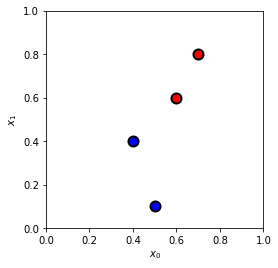

In [2]:
X = np.array([[0.5, 0.1], [0.4, 0.4], [0.6, 0.6], [0.7, 0.8]])
y = np.array([-1, -1, 1, 1])
y_pos = (y == 1)
y_neg = (y == -1)
plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.axes().set_aspect('equal')

The goal of the SVM is to classify new unknown points, such as the point $q$ indicated by the green square here.

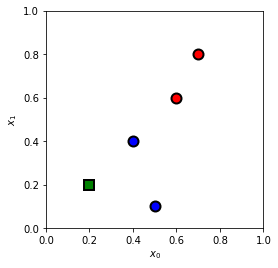

In [3]:
q = np.array([0.2, 0.2])
plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(q[0], q[1], '.', c='g', marker='s', markersize=10, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.axes().set_aspect('equal')

We'll use a Gaussian kernel $K_h$ with bandwidth $h$. That means that the value of $K_h(x, y)$ is the value of a 1-dimensional Gaussian centered at $0$ with $\sigma^2=h$, evaluated at a point a distance $|x-y|$ from the centre. A kernel is a *measure of similarity*, so $K$ will be large when $x$ and $y$ are close together.

In [4]:
def d(x, y):
    return scipy.linalg.norm(x - y) # Euclidean distance

def K(x, y):
    h = 0.5
    return np.exp(- d(x, y) / (2 * h**2.0))

Any point $q$ in the original space will be (implicitly) mapped to a point $z(q)$ in the new space, and that new point will have coordinates given by $K(q, x_i)$, for each of the support vectors $x_i$.

In [5]:
def z(q, SVs):
    return np.array([K(q, xi) for xi in SVs])

Our original training data maps to the new space as follows. For each point in the training data, and each support vector, we calculate $K$ between the training point and the SV, and that gives one feature $z_i$ for that training point. 

Let's suppose that we have exactly two support vectors, that is two of our training points become support vectors. (In a real example, the choice would be made by the quadratic programming training procedure, and there would not just be two.) It's useful to think of the SVs as the points which are closest to the boundary between classes, so we can see that the SVs will be the two points $(0.4, 0.4), (0.6, 0.6)$ -- one labelled -1, the other +1.

In [6]:
SVs = X[1:3]
Z = np.array([z(xi, SVs) for xi in X])
Z

array([[ 0.53128561,  0.36066566],
       [ 1.        ,  0.56797071],
       [ 0.56797071,  1.        ],
       [ 0.36787944,  0.63940732]])

Note the value 1.0, which occurs when evaluating $K(x, x)$, ie the similarity between a point and itself. It's the largest possible similarity.

We can also do the same for our query point $q$ whose label is unknown.

In [7]:
qz = z(q, SVs)
qz

array([ 0.56797071,  0.32259073])

Here, the value approximately 0.57 is a measure of similarity between the green query point and the first SV, that is the upper blue point. This value on $z_0$ is exactly the same as the value which one red point has for $z_0$. Why? Because in the original space, that red SV and the green triangle are equally distant from the blue SV.

Now let's look at the implicit new space. In our example, it is of two dimensions, the same as the original space, but that isn't usually the case! The number of dimensions in the new space is equal to the number of SVs. (The reason we created just two training points is so that we would have two SVs and the new implicit feature space could be plotted easily.)

The training data and query points are plotted in the new space. We'll plot a good-looking separating hyperplane also, and see that the query point ends up on the "blue" side of it as it should. (In reality, the hyperplane is determined by training, but we won't discuss it.) The hyperplane is indeed a hyperplane here, ie a line and not a curve, because the SVM is a linear classifier in the new implicit space. It may be non-linear when we view the decision function in the original space.

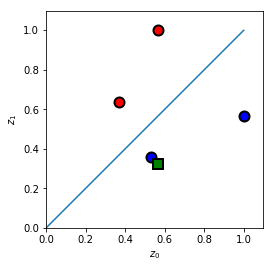

In [15]:
plt.plot(Z[y_neg, 0], Z[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(Z[y_pos, 0], Z[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(qz[0], qz[1], '.', c='g', marker='s', markersize=10, mew=2, mec='k')
plt.plot((0, 1), (0, 1))
plt.xlabel(r"$z_0$")
plt.ylabel(r"$z_1$")
plt.xlim((0, 1.1))
plt.ylim((0, 1.1))
plt.axes().set_aspect('equal')

We can *see* the decision for the query point by seeing which side of the line it falls on. But how do we actually calculate the decision? We have a weight $w_i$ for each SV. The line is determined by the $w$. The decision function for a query point $q$ is just $\sum_i w_i K(q, x_i) > 0$ where $x_i$ are the SVs: if yes (greater than 0), the output is +1, else -1.

In our simple example, we'll set the weights $w$ to good values manually: $w = [-1, 1]$ (remember, one weight per SV). That means that similarity to the first SV should give a *negative* contribution to the decision value, leading to a -1 outcome; similarity to the second SV should give a *positive* contribution, leading to a +1 outcome. (In our example we choose good weights by hand, but in reality, the training by QP will give us the weights. We won't discuss the QP in this notebook.)

In [9]:
x = np.linspace(0, 1, 11)
z_0, z_1 = np.meshgrid(x, x)

In [10]:
def decision_value(q, SVs):
    w = [-1, 1] # One weight per SV
    wx = np.sum(w[i] * K(q, SVs[i]) for i in range(len(SVs)))
    return wx

def decision_function(q, SVs):
    if decision_value(q, SVs) > 0: return +1
    else                         : return -1

For example, the decision value for $q$ is negative:

In [11]:
decision_value(q, SVs)

-0.24537998230855557

In [12]:
decision_function(q, SVs)

-1

Now, we can plot the decision value over the original space, and superimpose the training data and query point.

In [13]:
g = 101
grid = np.linspace(0, 1, g)
im = np.zeros((g, g))
for i in range(g):
    for j in range(g):
        im[i, j] = decision_value((grid[i], grid[j]), SVs)

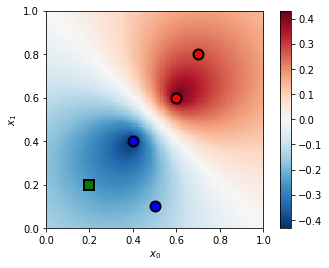

In [14]:
plt.imshow(im, origin='lower', extent=(0, 1, 0, 1), cmap='RdBu_r')
plt.colorbar()
plt.plot(X[y_neg, 0], X[y_neg, 1], '.', c='b', markersize=20, mew=2, mec='k')
plt.plot(X[y_pos, 0], X[y_pos, 1], '.', c='r', markersize=20, mew=2, mec='k')
plt.plot(q[0], q[1], '.', c='g', marker='s', markersize=10, mew=2, mec='k')
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.axes().set_aspect('equal')

Hey, why isn't the decision boundary non-linear as promised? Well, because we only have two SVs. With more SVs, the decision boundary would still be linear in the new (now higher-dimensional) space, but non-linear in the original space. But we can already see non-linear behaviour of the decision *value* plotted above.

Conclusion
---

So, an SVM can be seen as an algorithm which decides the label of a query point by testing whether it is more similar to a subset (the SVs) of the +1 examples, or to a subset (the SVs) of the -1 examples -- specifically, which side of the hyperplane it falls on, when it and the SVs are mapped to a space defined by similarity to the SVs, and a hyperplane is drawn to maximise the margin between the two classes. (The margin may also be "soft", ie allowing for a few training points on the wrong side of the hyperplane, but we won't discuss it.) Similarity is measured by the kernel, based ultimately on an inverse mapping of Euclidean distance. In this sense, an SVM is closely related to techniques such as $k$ nearest neighbours, kernel density classification, and dissimilarity representations (eg Duin & Pekalska, Pattern Recognition Letters 33 (2012) 826–832). 

Thanks to Stefano Mauceri and Loi Van Cao for useful discussions on these topics.